## Notebook 4: IMDB Score Modeling - Capstone

### Introduction to Notebook: 

This is the 2nd notebook dedicated to modeling, this time on the IMDB score (measure of the quality of the movie). 

As we delved into detail in the prior notebook (modeling the IMDB votes) about each model and the different hyperparameters, **I won't get into as much detail in this one.**

Note : After a few initial attempts at modeling this as a regression problem, I turn it into a multi-class classification problem.

## Table of Contents


#### [Part 1 - Regression Problem](#1.1)

[1 - Getting a Baseline with Linear Regression](#1.1)

[2 - Ridge and Lasso Regression](#1.2)

[3 - K Nearest Neighbours](#1.3)

[4 - Decision Trees](#1.4)

[5 - Random Forests](#1.5)

[6 - ADABoost](#1.6)

[7 - XGBoost](#1.7)



#### [Part 2 - Classification Problem](#2)

[1 - Exploring Upsampling the data](#2.1)

[2 - Logistic Regression](#2.2)

[3 - K Nearest Neighbours](#2.3)

[4 - Support Vector Classification](#2.4)

[5 - Tuning XGBoost prior to Grid Search](#2.5)

[6 - GridSearch with Cross Validation](#2.6)

[7 - Model Evaluation](#2.7)


#### [Conclusion](#Conclusion_)

In [11]:
# Installing Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# To split the data as necessary for modelling
from sklearn.model_selection import train_test_split

# To get rid of logistic regression default solver warnings that appear if sklearn hasn't been updated
import warnings
warnings.filterwarnings('ignore')

# To "pickle" things, like accuracies or even an entire fitted model
import joblib

# To cross-validate
from sklearn.model_selection import cross_val_score

# To set up a temporary directory for caching pipeline results
from tempfile import mkdtemp

# To build a pipeline
from sklearn.pipeline import Pipeline

# To try scaling the data in various ways
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# To try dimensionality reduction
from sklearn.decomposition import PCA

# To do a cross-validated grid search
from sklearn.model_selection import GridSearchCV

In [151]:
df = pd.read_csv('data/ready_for_modeling.csv')

In [152]:
df.head(10)

,type,release_year,runtime,seasons,imdb_score,imdb_votes,Superstars,Allstars,Supporting_Actors,Other_Actors,...,title_white,title_wild,title_wolf,title_woman,title_women,title_world,title_year,title_years,title_york,title_young
0,1,1976,114,0.0,8.2,808582.0,1,0,1,35,...,0,0,0,0,0,0,0,0,0,0
1,1,1972,109,0.0,7.7,107673.0,0,0,2,21,...,0,0,0,0,0,0,0,0,0,0
2,1,1975,91,0.0,8.2,534486.0,0,1,3,44,...,0,0,0,0,0,0,0,0,0,0
3,1,1967,150,0.0,7.7,72662.0,0,1,1,53,...,0,0,0,0,0,0,0,0,0,0
4,0,1969,30,4.0,8.8,73424.0,0,1,2,2,...,0,0,0,0,0,0,0,0,0,0
5,1,1979,94,0.0,8.0,395024.0,0,1,3,18,...,0,0,0,0,0,0,0,0,0,0
6,1,1971,102,0.0,7.7,155051.0,1,0,0,57,...,0,0,0,0,0,0,0,0,0,0
7,1,1967,110,0.0,7.7,112048.0,0,2,1,14,...,0,0,0,0,0,0,0,0,0,0
8,1,1980,104,0.0,5.8,69844.0,0,0,1,13,...,0,0,0,0,0,0,0,0,0,0
9,1,1961,158,0.0,7.5,50748.0,0,0,4,20,...,0,0,0,0,0,0,0,0,0,0


Focusing only on the IMDB score column for now

In [153]:
X = df.drop(columns = ['imdb_score','imdb_votes'])
y = df['imdb_score']

In [15]:
y.head()

type
1    8.2
1    7.7
1    8.2
1    7.7
0    8.8
Name: imdb_score, dtype: float64

In [154]:
X.head()

,type,release_year,runtime,seasons,Superstars,Allstars,Supporting_Actors,Other_Actors,oscar_acting,oscar_directing,...,title_white,title_wild,title_wolf,title_woman,title_women,title_world,title_year,title_years,title_york,title_young
0,1,1976,114,0.0,1,0,1,35,2,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1972,109,0.0,0,0,2,21,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1975,91,0.0,0,1,3,44,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1967,150,0.0,0,1,1,53,3,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1969,30,4.0,0,1,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [155]:
#Not using stratify=y as giving an error, plus this is a regression problem
#not a classification one

X_rem, X_test, y_rem, y_test = \
train_test_split(X, y, \
                 test_size=0.25, random_state=23)

Further splitting into train and validation.

In [156]:
X_train, X_val, y_train, y_val = \
train_test_split(X_rem, y_rem, \
                 test_size=0.2, random_state=23)

### 1.1

### Getting a Baseline with Linear Regression

In [157]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Train set predictions
y_pred_train = linear_model.predict(X_train)

# Validation set predictions
y_pred_val = linear_model.predict(X_val)

print("Linear Regression")

# Train set scores
print("Train Set:")
print("Mean Squared Error:", mean_squared_error(y_train, y_pred_train))
print("R2 Score:", r2_score(y_train, y_pred_train))
print()

# Validation set scores
print("Validation Set:")
print("Mean Squared Error:", mean_squared_error(y_val, y_pred_val))
print("R2 Score:", r2_score(y_val, y_pred_val))
print()

Linear Regression
Train Set:
Mean Squared Error: 0.964666708630342
R2 Score: 0.398918469155356

Validation Set:
Mean Squared Error: 1.130160683243944
R2 Score: 0.29913052548584973



So this is the baseline, a validation score of 0.224 with linear regression. Let's try ridge and lasso regression next. As scaling is important for Ridge and Lasso, I'll scale the features first.

### 1.2

### Ridge Regression

In [158]:
#Scaling

scaler = StandardScaler()
scaler.fit(X_train)

X_train_ss = scaler.transform(X_train)

X_val_ss = scaler.transform(X_val)

In [159]:
from sklearn.linear_model import Ridge, Lasso

ridge = Ridge(alpha=1000)
ridge.fit(X_train_ss, y_train)

y_pred_train = ridge.predict(X_train_ss)
y_pred_val = ridge.predict(X_val_ss)

print("Ridge regression")
# Train set scores
print("Train Set:")
print("Mean Squared Error:", mean_squared_error(y_train, y_pred_train))
print("R2 Score:", r2_score(y_train, y_pred_train))
print()

# Validation set scores
print("Validation Set:")
print("Mean Squared Error:", mean_squared_error(y_val, y_pred_val))
print("R2 Score:", r2_score(y_val, y_pred_val))
print()

Ridge regression
Train Set:
Mean Squared Error: 0.9765542809846165
R2 Score: 0.39151135110638846

Validation Set:
Mean Squared Error: 1.123227456985903
R2 Score: 0.30343016775460485



In [160]:
#Now creating the For loop to look at optimal values for alpha in Ridge regression

train_acc=[]
val_acc=[]
alpha_list = [0.1,1,10,100,1000,10000]

for n in alpha_list:
    
    print(f'Now running the Ridge model with alpha={n}', end='\r')
    
    # Instantiate the KNN model 
    ridge = Ridge(alpha=n)
    ridge.fit(X_train_ss, y_train)
    
    train_accuracy = ridge.score(X_train_ss, y_train)
    val_accuracy = ridge.score(X_val_ss, y_val)
    
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)

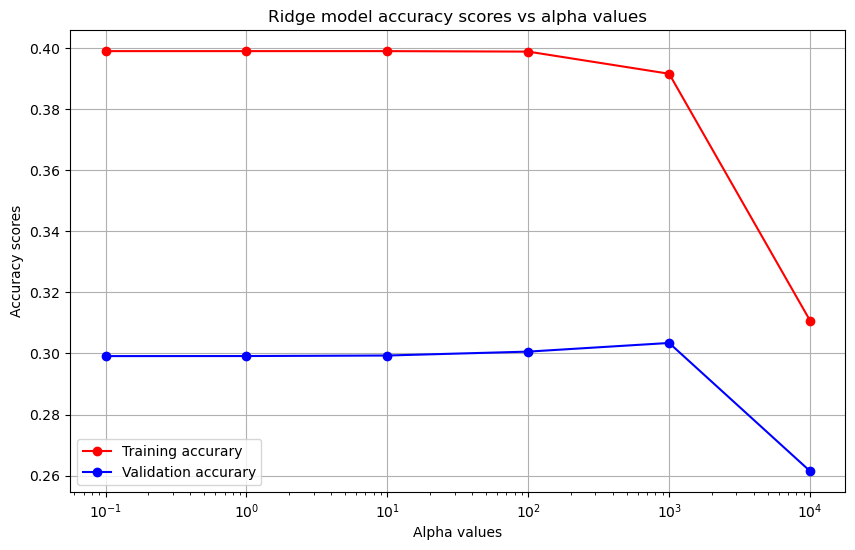

In [161]:
#Plotting this with a log scale for the X-axis for better interpretability

plt.figure(figsize=(10,6))
plt.plot(alpha_list, train_acc, color='red', label = 'Training accurary', marker = 'o')
plt.plot(alpha_list, val_acc, color='blue', label = 'Validation accurary', marker = 'o')
plt.xscale('log') #Using a log scale to better spread out the values
plt.xlabel('Alpha values')
plt.ylabel('Accuracy scores')
plt.title('Ridge model accuracy scores vs alpha values')
plt.legend()
plt.grid()
plt.show()

None of these are great as the R2 score is quite low, plus the model is overfitting (relatively speaking) on the training data as the difference in training and validation scores is quite high.

In [162]:
#Saving this information

Ridge_scores = pd.DataFrame({'alpha values': alpha_list, 'training score': train_acc, \
                          'validation score': val_acc})

#Code to find the difference between training and validation scores, expressed as a % of validations score.
Ridge_scores['Train Percent difference vs. Val'] = round(((Ridge_scores['training score']/\
                                              Ridge_scores['validation score']) - 1)*100,1)
Ridge_scores

,alpha values,training score,validation score,Train Percent difference vs. Val
0,0.1,0.398918,0.299131,33.4
1,1.0,0.398918,0.299149,33.4
2,10.0,0.398916,0.299322,33.3
3,100.0,0.398760,0.300599,32.7
4,1000.0,0.391511,0.303430,29.0
5,10000.0,0.310742,0.261496,18.8


### Lasso Regression

In [163]:
#Now creating the For loop to look at optimal values for alpha in lasso regression

train_acc=[]
val_acc=[]
alpha_list = [0.001, 0.01, 0.1,1,10,100]

for n in alpha_list:
    
    print(f'Now running the Ridge model with alpha={n}', end='\r')
    
    # Instantiate the KNN model 
    lasso = Lasso(alpha=n)
    lasso.fit(X_train_ss, y_train)
    
    train_accuracy = lasso.score(X_train_ss, y_train)
    val_accuracy = lasso.score(X_val_ss, y_val)
    
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)
    

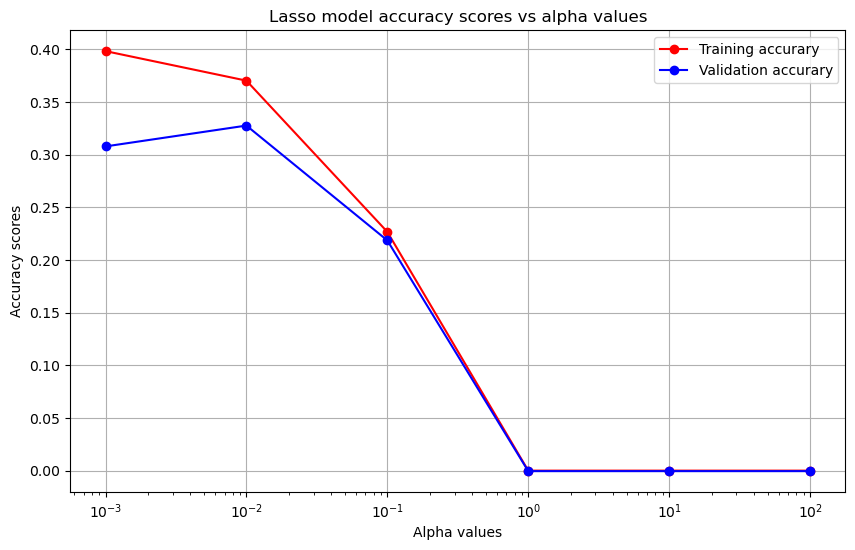

In [164]:
#Plotting this with a log scale for the X-axis for better interpretability

plt.figure(figsize=(10,6))
plt.plot(alpha_list, train_acc, color='red', label = 'Training accurary', marker = 'o')
plt.plot(alpha_list, val_acc, color='blue', label = 'Validation accurary', marker = 'o')
plt.xscale('log') #Using a log scale to better spread out the values
plt.xlabel('Alpha values')
plt.ylabel('Accuracy scores')
plt.title('Lasso model accuracy scores vs alpha values')
plt.legend()
plt.grid()
plt.show()

A little bit better than the Ridge regression, but not great in absolute terms.

In [165]:
#Saving this information

Lasso_scores = pd.DataFrame({'alpha values': alpha_list, 'training score': train_acc, \
                          'validation score': val_acc})

#Code to find the difference between training and validation scores, expressed as a % of validations score.
Lasso_scores['Train Percent difference vs. Val'] = round(((Lasso_scores['training score']/\
                                              Lasso_scores['validation score']) - 1)*100,1)
Lasso_scores

,alpha values,training score,validation score,Train Percent difference vs. Val
0,0.001,0.398279,0.307814,29.4
1,0.010,0.370246,0.327601,13.0
2,0.100,0.226683,0.218567,3.7
3,1.000,0.000000,-0.000466,-100.0
4,10.000,0.000000,-0.000466,-100.0
5,100.000,0.000000,-0.000466,-100.0


### 1.3

### K Nearest Neighbours

In [166]:
from sklearn.neighbors import KNeighborsRegressor

Trying PCA as it can benefit a KNN model.

In [167]:
#Trying PCA

my_PCA = PCA(n_components=0.9)

X_train_pca_ss = my_PCA.fit_transform(X_train_ss)
X_val_pca_ss = my_PCA.transform(X_val_ss)

In [168]:
#Creating a function to get the Fibonacci sequence

def fibonacci(n):
   
    # If input is negative then it will print incorrect input
    if n < 0:
        print("Incorrect input")
 
    # If n is 0 then it will return 0
    elif n == 0:
        return 0
 
    # If n is 1,2 it will return 1 (the first 2 values of the sequence)
    elif n == 1 or n == 2:
        return 1
 
    else:
        return fibonacci(n-1) + fibonacci(n-2)
     

In [169]:
#Check to see if it works

fib_list = []
for i in np.arange(2,15,1): #starting from 2 as we want to being with 1,2....
    fib_list.append(fibonacci(i))
    
print (fib_list)

[1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377]


In [170]:
#Now creating the For loop to look at optimal values for the number of neighbours

train_acc=[]
val_acc=[]

for n in fib_list:
    
    print(f'Now running the KNN model with n={n}', end='\r')
    
    # Instantiate the KNN model 
    KNN_model= KNeighborsRegressor(n_neighbors = n)
    KNN_model.fit(X_train_pca_ss, y_train)
    
    train_accuracy = KNN_model.score(X_train_pca_ss, y_train)
    val_accuracy = KNN_model.score(X_val_pca_ss, y_val)
    
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)

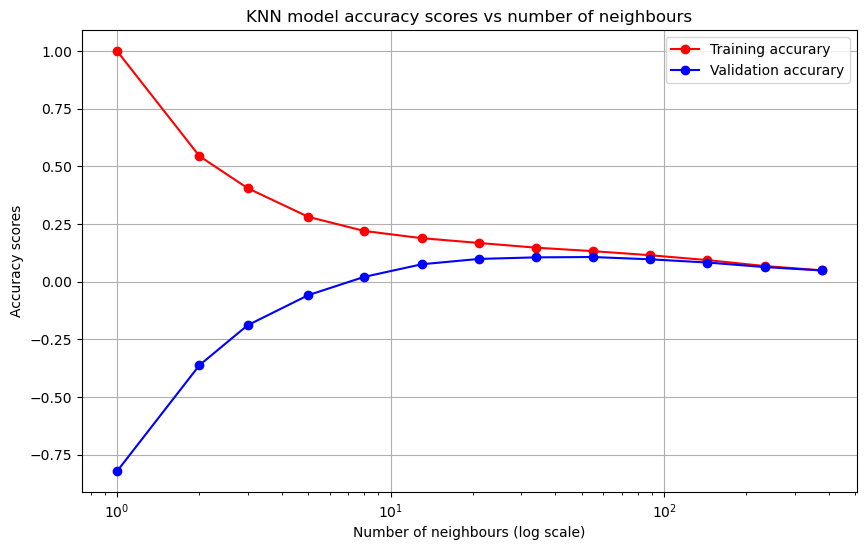

In [171]:
#Plotting this with a log scale for the X-axis for better interpretability

plt.figure(figsize=(10,6))
plt.plot(fib_list, train_acc, color='red', label = 'Training accurary', marker = 'o')
plt.plot(fib_list, val_acc, color='blue', label = 'Validation accurary', marker = 'o')
plt.xscale('log') #Using a log scale to better spread out the values
plt.xlabel('Number of neighbours (log scale)')
plt.ylabel('Accuracy scores')
plt.title('KNN model accuracy scores vs number of neighbours')
plt.legend()
plt.grid()
plt.show()

This is the worst performing model so far. Similar to the IMDB votes modeling, it seems like KNN is not a great fit for this data.

### 1.4

### Decision Trees

In [172]:
from sklearn.tree import DecisionTreeRegressor

In [173]:
dt_baseline = DecisionTreeRegressor(random_state=42)
dt_baseline.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [174]:
train_acc=[]
val_acc=[]
depth_range = np.arange(1,30,2)

for d in depth_range:
    
    print(f'Now running the Decision Trees Model with max depth={d}', end='\r')
    
    # Instantiate the KNN model 
    dt= DecisionTreeRegressor(max_depth=d,random_state=42)
    dt.fit(X_train, y_train)
    
    train_accuracy = dt.score(X_train, y_train)
    val_accuracy = dt.score(X_val, y_val)
    
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)

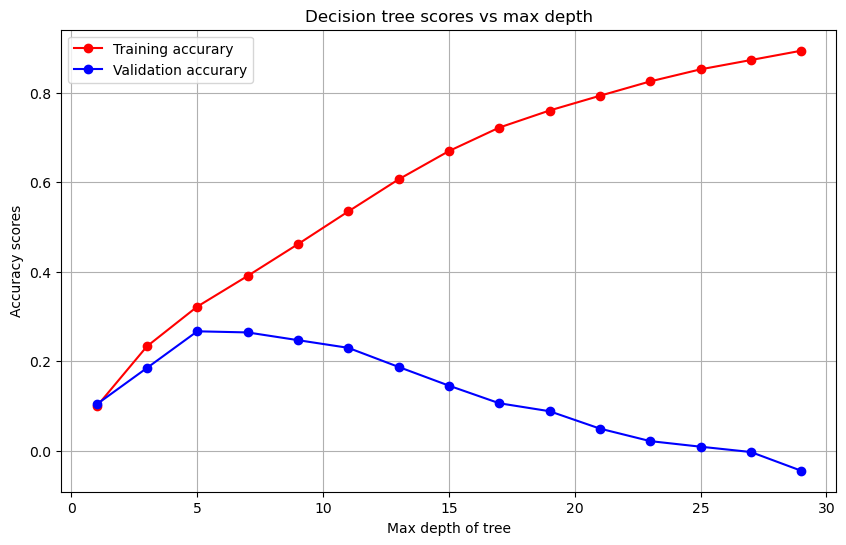

In [175]:
plt.figure(figsize=(10,6))
plt.plot(depth_range, train_acc, color='red', label = 'Training accurary', marker = 'o')
plt.plot(depth_range, val_acc, color='blue', label = 'Validation accurary', marker = 'o')
plt.xlabel('Max depth of tree')
plt.ylabel('Accuracy scores')
plt.title('Decision tree scores vs max depth')
plt.legend()
plt.grid()
plt.show()

In [177]:
#Saving the scores

DT_scores = pd.DataFrame({'max_depth': depth_range, 'training score': train_acc, \
                          'validation score': val_acc})

DT_scores['Train Percent difference vs. Val'] = round(((DT_scores['training score']/\
                                              DT_scores['validation score']) - 1)*100,1)

DT_scores.head(5)

,max_depth,training score,validation score,Train Percent difference vs. Val
0,1,0.099054,0.103832,-4.6
1,3,0.233516,0.185184,26.1
2,5,0.322288,0.267082,20.7
3,7,0.390791,0.264583,47.7
4,9,0.461812,0.247320,86.7


This has the best scores so far (slightly) with the 0.27 R2 score for max_depth = 5.

## Ensemble Learning

### 1.5

### Random Forests

Moving on to random forests.

In [46]:
from sklearn.ensemble import RandomForestRegressor

Similar to what we did in IMDB votes for the ensemble learning methods, I'll be tuning one hyperparameter at a time of the 2 main hyperparameters (n_estimators and max_depth).

In [178]:
#TUning the n_estimators
n_range = range(5,100,10)
train_acc = []
val_acc = []


for n in n_range:
    
    print(f'Now running random forests with n={n}', end='\r')
    
    RF = RandomForestRegressor(n_estimators= n)
    
    RF.fit(X_train, y_train)
    
    train_acc.append(RF.score(X_train, y_train))
    val_acc.append(RF.score(X_val, y_val))
    

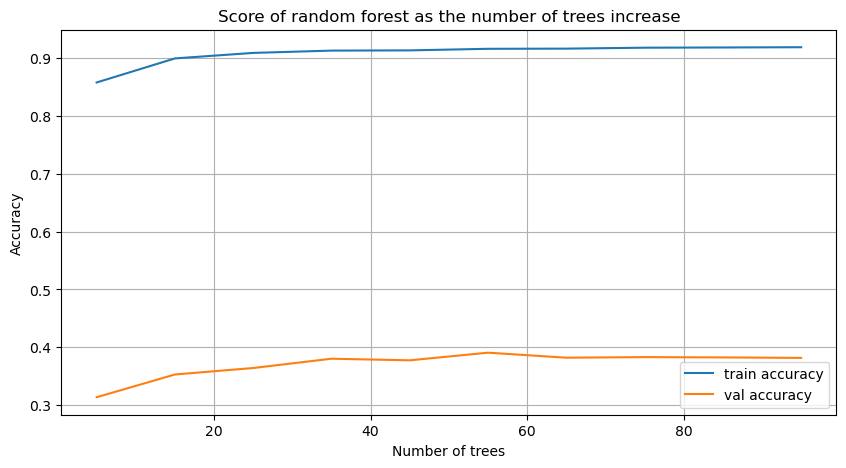

In [179]:
plt.figure(figsize=(10,5))
plt.plot(n_range, train_acc, label='train accuracy')
plt.plot(n_range, val_acc, label='val accuracy')

plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.title("Score of random forest as the number of trees increase")
plt.grid()
plt.legend()
plt.show()

The difference between the train and validation scores is about the same no matter the number of estimators. Let's then go with the estimators that have the highest accuracy, which is n=95

In [180]:
d_range = range(3,50,5)
train_acc = []
val_acc = []


for d in d_range:
    
    print(f'Now running random forests with max_depth={d}', end='\r')
    
    RF = RandomForestRegressor(n_estimators= 95, max_depth=d)
    
    RF.fit(X_train, y_train)
    
    train_acc.append(RF.score(X_train, y_train))
    val_acc.append(RF.score(X_val, y_val))

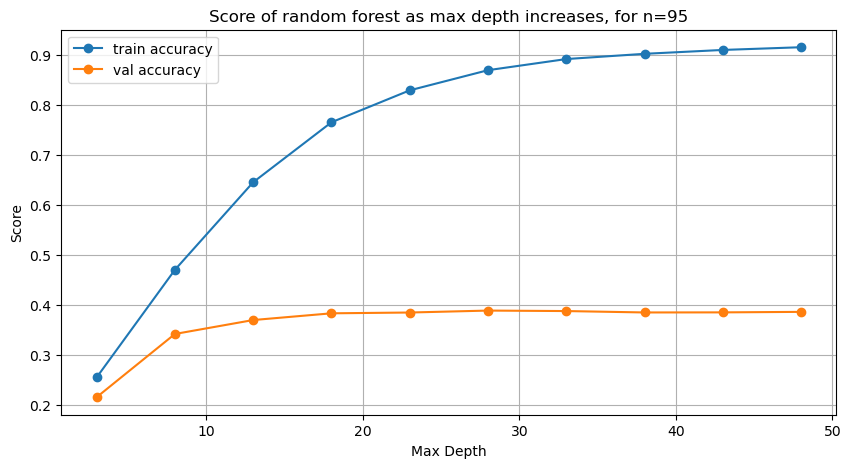

In [181]:
plt.figure(figsize=(10,5))
plt.plot(d_range, train_acc, label='train accuracy', marker='o')
plt.plot(d_range, val_acc, label='val accuracy', marker='o')

plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title("Score of random forest as max depth increases, for n=95")
plt.grid()
plt.legend()
plt.show()

Trying again with a lower n_estimators and a smaller range of max_depth.

In [55]:
d_range = range(3,30,5)
train_acc = []
val_acc = []


for d in d_range:
    
    print(f'Now running random forests with max_depth={d}', end='\r')
    
    RF = RandomForestRegressor(n_estimators= 55, max_depth=d)
    
    RF.fit(X_train, y_train)
    
    train_acc.append(RF.score(X_train, y_train))
    val_acc.append(RF.score(X_val, y_val))

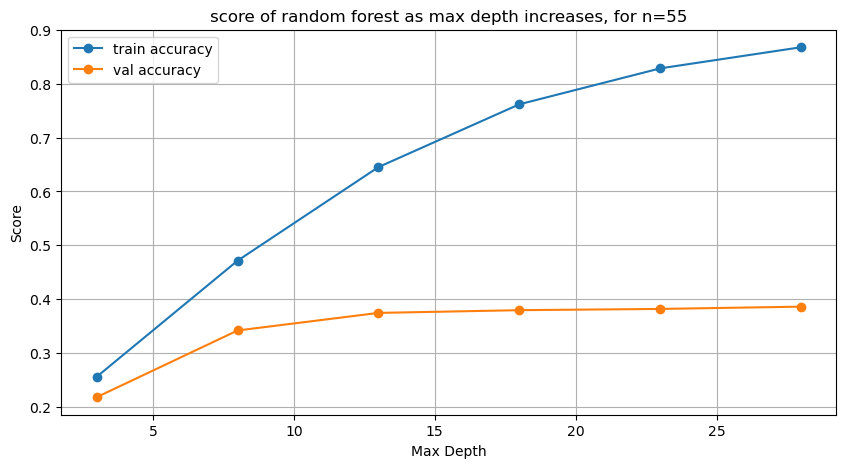

In [58]:
plt.figure(figsize=(10,5))
plt.plot(d_range, train_acc, label='train accuracy', marker='o')
plt.plot(d_range, val_acc, label='val accuracy', marker='o')

plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title("Score of random forest as max depth increases, for n=55")
plt.grid()
plt.legend()
plt.show()

In [59]:
RF_scores = pd.DataFrame({'max_depth': d_range, 'training score': train_acc, \
                          'validation score': val_acc})
RF_scores['Train Percent difference vs. Val'] = round(((RF_scores['training score']/\
                                              RF_scores['validation score']) - 1)*100,1)

RF_scores

,max_depth,training score,validation score,Train Percent difference vs. Val
0,3,0.255872,0.218041,17.3
1,8,0.471450,0.341904,37.9
2,13,0.645201,0.374542,72.3
3,18,0.761774,0.379621,100.7
4,23,0.828469,0.381935,116.9
5,28,0.867703,0.386156,124.7


Highest validation scores so far but the model is clearly overfitting at the higher max_depth values.

### 1.6

### Adaboost

In [49]:
from sklearn.ensemble import AdaBoostRegressor

In [63]:
#Finding out best number of estimators

n_range = range(1,50,5)
train_acc = []
val_acc = []


for n in n_range:
    
    print(f'Now running Adaboost with n={n}', end='\r')
    
    ada = AdaBoostRegressor(n_estimators= n, random_state=28)
    
    ada.fit(X_train, y_train)
    
    train_acc.append(ada.score(X_train, y_train))
    val_acc.append(ada.score(X_val, y_val))

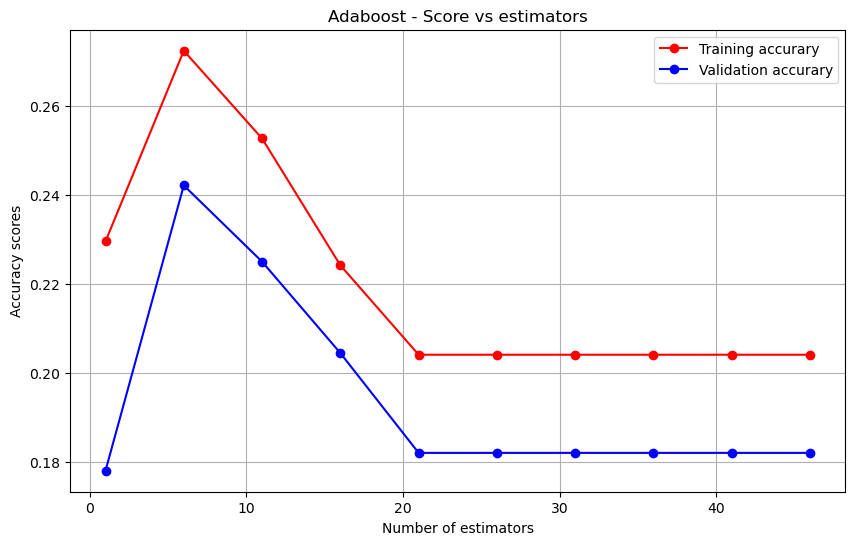

In [64]:
plt.figure(figsize=(10,6))
plt.plot(n_range, train_acc, color='red', label = 'Training accurary', marker = 'o')
plt.plot(n_range, val_acc, color='blue', label = 'Validation accurary', marker = 'o')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy scores')
plt.title('Adaboost - Score vs estimators')
plt.legend()
plt.grid()
plt.show()

These are not great scores compared to the other models we've seen so far. Moving ahead to XGBoost.

### 1.8

### XGBoost

In [66]:
from xgboost import XGBRegressor

In [80]:
#Finding best number of estimators

n_range = range(5,101,10)
train_acc = []
val_acc = []

for n in n_range:
    
    print(f'Now running XGBoost with n_estimator={n}', end='\r')
    
    xgb = XGBRegressor(n_estimators=n)
    
    xgb.fit(X_train, y_train)
    
    train_acc.append(xgb.score(X_train, y_train))
    val_acc.append(xgb.score(X_val, y_val))

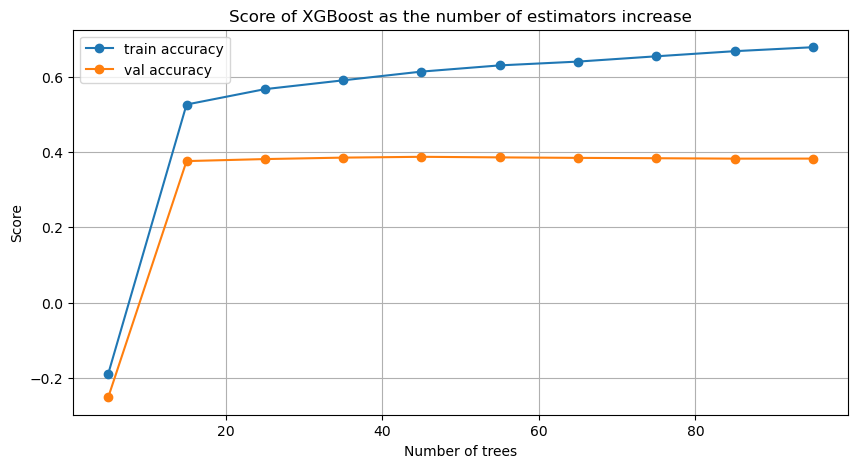

In [81]:
plt.figure(figsize=(10,5))
plt.plot(n_range, train_acc, label='train accuracy', marker='o')
plt.plot(n_range, val_acc, label='val accuracy', marker='o')

plt.xlabel('Number of trees')
plt.ylabel('Score')
plt.title("Score of XGBoost as the number of estimators increase")
plt.grid()
plt.legend()
plt.show()

In [82]:
#Finding best depth

d_range = range(3,50,5)
train_acc = []
val_acc = []

for d in d_range:
    
    print(f'Now running XGBoost with max_depth={d}', end='\r')
    
    xgb = XGBRegressor(n_estimators=15, max_depth=d)
    
    xgb.fit(X_train, y_train)
    
    train_acc.append(xgb.score(X_train, y_train))
    val_acc.append(xgb.score(X_val, y_val))

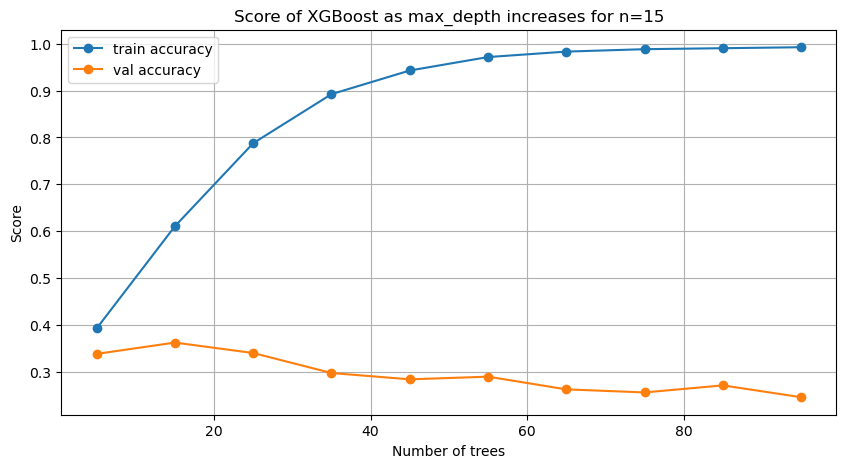

In [83]:
plt.figure(figsize=(10,5))
plt.plot(n_range, train_acc, label='train accuracy', marker='o')
plt.plot(n_range, val_acc, label='val accuracy', marker='o')

plt.xlabel('Number of trees')
plt.ylabel('Score')
plt.title("Score of XGBoost as max_depth increases for n=15")
plt.grid()
plt.legend()
plt.show()

The best scores so far, however in general any of the models don't seem to be doing too well with this as a regression problem.

## 2

## Turning this into a multi-class classification problem

So we've gotten this far with some small improvements in the model as we tried everything from linear, ride & lasso regressions to KNN, decision trees and ensemble methods like random forests, ADA and XGBoost. The best methods yielded a validation score higher than 0.4 but in all cases there was some degree of overfitting happening.

At this point, I've decided to make a fundamental change in the how I'm approaching this. Let's first have another look at the distribution of IMDB scores.

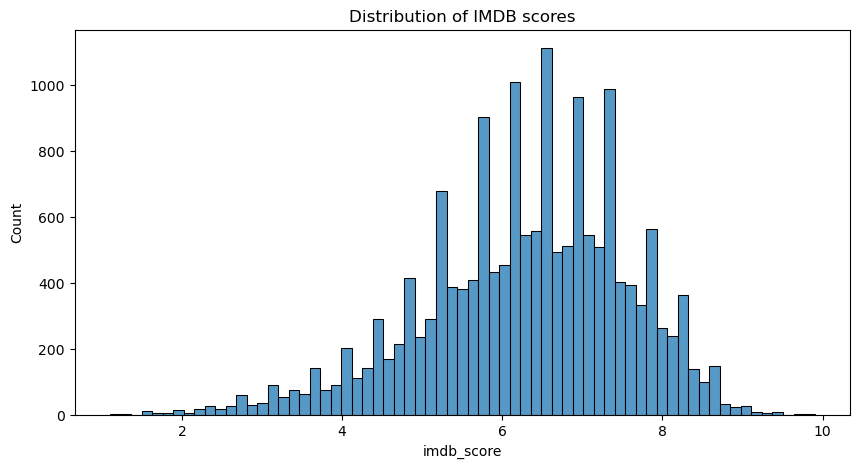

In [69]:
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='imdb_score')
plt.title('Distribution of IMDB scores')
plt.show()

Looks like a normal-ish distribution but the model might struggle to correctly identify the higher scoring titles, which is what we are interested in disproportionately.

What I mean is - when someone is looking at the IMDB score of a title, they don't need to know the exact number - just the range. Broadly speaking, this is what people bucket different IMDB scores into:

| Score Range |                Interpretation               |
|:-----------:|:-------------------------------------------:|
|    0 - 5    |             Never going to watch            |
|   5 - 6.5   |          If there's nothing else on         |
|  6.5 - 7.5  |             Might be interested             |
|  7.5 - 8.5  |             Good to great movie             |
|     8.5+    | Excellent, potentially all-time great movie |

So my plan here is to create a multi-class classification problem and then upsample the lowest frequency class (which is going to be all titles with a imdb_score higher than 8.5) to train the model better.

In [182]:
df_class = pd.read_csv('data/ready_for_modeling.csv')

In [184]:
df_class.sample(5)

,type,release_year,runtime,seasons,imdb_score,imdb_votes,Superstars,Allstars,Supporting_Actors,Other_Actors,...,title_white,title_wild,title_wolf,title_woman,title_women,title_world,title_year,title_years,title_york,title_young
3219,0,2020,43,2.0,5.9,1240.0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
13481,1,2016,97,0.0,6.6,75898.0,0,1,2,56,...,0,0,0,0,0,0,0,0,0,0
13474,1,2015,93,0.0,5.1,17198.0,1,0,0,28,...,0,0,0,0,0,0,0,0,0,0
4825,1,2021,118,0.0,4.9,1989.0,0,0,0,14,...,0,0,0,0,0,0,0,0,0,0
6953,0,2016,26,3.0,7.2,3842.0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0


In [191]:
#Creating the bins 

#Class 0
df_class['imdb_score'] = np.where(df_class['imdb_score']<5, 0, df_class['imdb_score'])

#Class 1
df_class['imdb_score'] = np.where(((df_class['imdb_score']>=5) & (df_class['imdb_score']<6.5)), 1, df_class['imdb_score'])
                 
#Class 2
df_class['imdb_score'] = np.where(((df_class['imdb_score']>=6.5) & (df_class['imdb_score']<7.5)), 2, df_class['imdb_score'])

#Class 3
df_class['imdb_score'] = np.where(((df_class['imdb_score']>=7.5) & (df_class['imdb_score']<8.5)), 3, df_class['imdb_score'])

#Class 4
df_class['imdb_score'] = np.where(df_class['imdb_score']>=8.5, 4, df_class['imdb_score'])

In [192]:
df_class['imdb_score'].value_counts(normalize=True)

1.0    0.372922
2.0    0.304691
3.0    0.159917
0.0    0.141568
4.0    0.020903
Name: imdb_score, dtype: float64

In [195]:
baseline = df_class['imdb_score'].value_counts(normalize=True)[1]

In [196]:
baseline

0.37292161520190026

So the **base accuracy** for this model would be 0.372, meaning if the model guessed that all the datapoints were the class with the highest frequency (class 1) then it would be 37.2% correct.

### 2.1

### Trying Upsampling

Since class 4 is our highest quality content but is only 2% of the dataset, I'm going to upsample this. Before we do that, let's get a sense of how the model performs without upsampling the lowest frequency class, just to understand how much of a difference changing from regression to classification is making, vs adding the step of upsampling.

In [205]:
# Separate the feature and target data
A = df_class.drop(columns = ['imdb_score','imdb_votes'])
b = df_class['imdb_score']

# Split the data into remainder and testing sets
A_rem, A_test, b_rem, b_test = train_test_split(A, b, test_size=0.2, random_state=42, stratify=b)

# Split the remainder into training and validation sets
A_train, A_val, b_train, b_val = train_test_split(A_rem, b_rem, \
                                                    test_size=0.2, random_state=42, stratify=b_rem)


In [206]:
from xgboost import XGBClassifier

In [207]:
n_range = range(5,101,10)
train_acc = []
val_acc = []


for n in n_range:
    
    print(f'Now running XGBoost with n={n}', end='\r')
    
    xgb = XGBClassifier(n_estimators= n)
    
    xgb.fit(A_train, b_train)
    
    train_acc.append(xgb.score(A_train, b_train))
    val_acc.append(xgb.score(A_val, b_val))

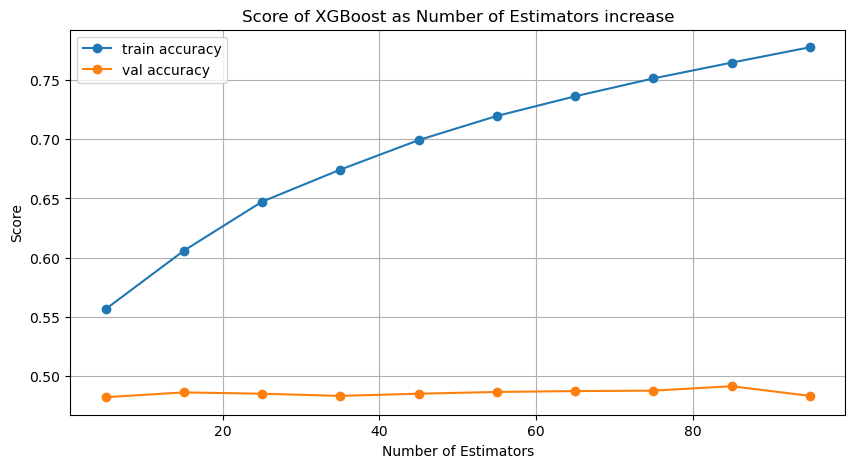

In [208]:
plt.figure(figsize=(10,5))
plt.plot(n_range, train_acc, label='train accuracy', marker='o')
plt.plot(n_range, val_acc, label='val accuracy', marker='o')

plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title("Score of XGBoost as Number of Estimators increase")
plt.grid()
plt.legend()
plt.show()

In [209]:
XGB_scores = pd.DataFrame({'n_estimators': n_range, 'training score': train_acc, \
                          'validation score': val_acc})
XGB_scores['Train Percent difference vs. Val'] = round(((XGB_scores['training score']/\
                                              XGB_scores['validation score']) - 1)*100,1)
XGB_scores

,n_estimators,training score,validation score,Train Percent difference vs. Val
0,5,0.556370,0.482004,15.4
1,15,0.605827,0.486085,24.6
2,25,0.647304,0.484972,33.5
3,35,0.674399,0.483117,39.6
4,45,0.699360,0.484972,44.2
5,55,0.719774,0.486456,48.0
6,65,0.736383,0.487199,51.1
7,75,0.751508,0.487570,54.1
8,85,0.764870,0.491280,55.7
9,95,0.777860,0.483117,61.0


Definitely an improvement vs the previous regression problem. Let's now see how upsampling can help push this accuracy higher.

In [86]:
from sklearn.utils import resample

In [87]:
# Separate the feature and target data
C = df_class.drop(columns = ['imdb_score','imdb_votes'])
d = df_class['imdb_score']

# Split the data into remainder and test sets
C_rem, C_test, d_rem, d_test = train_test_split(C, d, test_size=0.2, random_state=42, stratify=d)

# Split the remainder into training and validation sets
C_train, C_val, d_train, d_val = train_test_split(C_rem, d_rem, test_size=0.2, random_state=42, stratify=d_rem)

# Combine the training data into a single dataframe
train_df = pd.concat([C_train, d_train], axis=1)

# Separate the minority class and other classes based on imdb_score
majority_class = train_df[train_df['imdb_score'] != 4]
minority_class = train_df[train_df['imdb_score'] == 4]

# Upsample the minority class to match the frequency of the most frequrnt class
minority_upsampled = resample(minority_class,
                              replace=True,
                              n_samples=majority_class['imdb_score'].value_counts().max(),
                              random_state=42)

# Combine the other classes with the upsampled minority class
train_upsampled = pd.concat([majority_class, minority_upsampled])

# Split the upsampled data into features and target
C_train_upsampled = train_upsampled.drop('imdb_score', axis=1)
d_train_upsampled = train_upsampled['imdb_score']

# Verify the new class distribution in the upsampled training data
d_train_upsampled.value_counts(normalize=True)

1.0    0.275841
4.0    0.275841
2.0    0.225395
3.0    0.118257
0.0    0.104667
Name: imdb_score, dtype: float64

We see that the class with the lowest frequency (which was class 4), now matches the class with the highest frequency, class 1.

### XGBoost Classification with upsampled data

In [89]:
n_range = range(5,101,10)
train_acc = []
val_acc = []


for n in n_range:
    
    print(f'Now running XGBoost with n={n}', end='\r')
    
    xgb = XGBClassifier(n_estimators= n)
    
    xgb.fit(C_train_upsampled, d_train_upsampled)
    
    train_acc.append(xgb.score(C_train_upsampled, d_train_upsampled))
    val_acc.append(xgb.score(C_val, d_val))

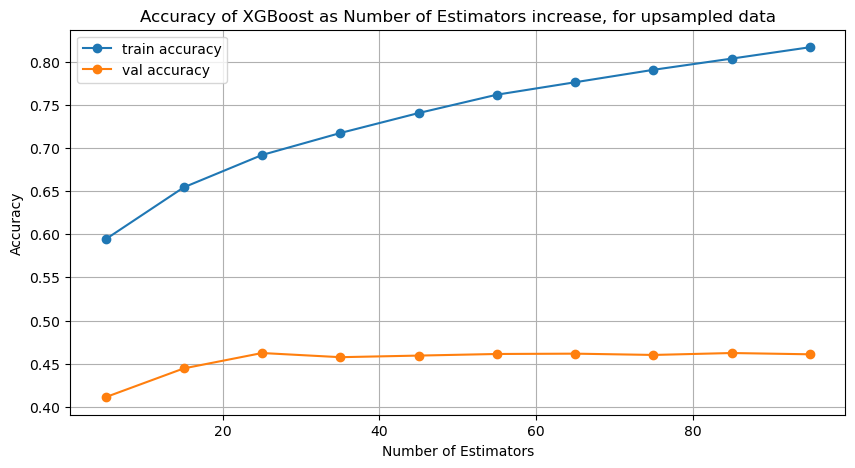

In [90]:
plt.figure(figsize=(10,5))
plt.plot(n_range, train_acc, label='train accuracy', marker='o')
plt.plot(n_range, val_acc, label='val accuracy', marker='o')

plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title("Accuracy of XGBoost as Number of Estimators increase, for upsampled data")
plt.grid()
plt.legend()
plt.show()

Doesn't seem to have made a difference (the scores are actually lower compared to the original data). It was worth exploring, but we can go back to the non-upsampled data.

### Going back to the non-upsampled data

We know XGBoost has been the best performing model so far, but given we've now turned this into a classification problem, we can try logistic regression.

### 2.2

### Logistic Regression

In [91]:
from sklearn.linear_model import LogisticRegression

In [94]:
c_values = [0.01, 0.1, 1, 100, 1000]
train_acc = []
val_acc = []

for c in c_values:
    
    print(f'Now running Logistic Regression with c ={c}', end='\r')
    
    logreg = LogisticRegression(C=c, random_state=42, max_iter=10000)
    
    logreg.fit(A_train, b_train)
    
    train_acc.append(logreg.score(A_train, b_train))
    val_acc.append(logreg.score(A_val, b_val))

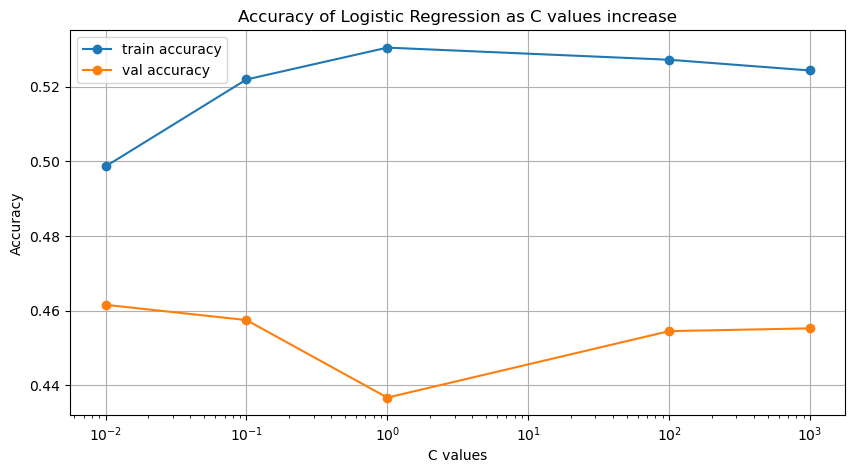

In [96]:
plt.figure(figsize=(10,5))
plt.plot(c_values, train_acc, label='train accuracy', marker='o')
plt.plot(c_values, val_acc, label='val accuracy', marker='o')

plt.xlabel('C values')
plt.ylabel('Accuracy')
plt.title("Accuracy of Logistic Regression as C values increase")
plt.xscale('log') #Using a log scale to better spread out the values
plt.grid()
plt.legend()
plt.show()

In [97]:
Logreg_scores = pd.DataFrame({'max_depth': c_values, 'training score': train_acc, \
                          'validation score': val_acc})
Logreg_scores['Train Percent difference vs. Val'] = round(((Logreg_scores['training score']/\
                                              Logreg_scores['validation score']) - 1)*100,1)

Logreg_scores

,max_depth,training score,validation score,Train Percent difference vs. Val
0,0.01,0.498655,0.461596,8.0
1,0.10,0.521945,0.457514,14.1
2,1.00,0.530482,0.436735,21.5
3,100.00,0.527234,0.454545,16.0
4,1000.00,0.524357,0.455288,15.2


Checking a couple of of additional C-values

In [98]:
c_values = [0.0001, 0.001, 10000]
train_acc = []
val_acc = []

for c in c_values:
    
    print(f'Now running Logistic Regression with c ={c}', end='\r')
    
    logreg = LogisticRegression(C=c, random_state=42, max_iter=10000)
    
    logreg.fit(A_train, b_train)
    
    train_acc.append(logreg.score(A_train, b_train))
    val_acc.append(logreg.score(A_val, b_val))

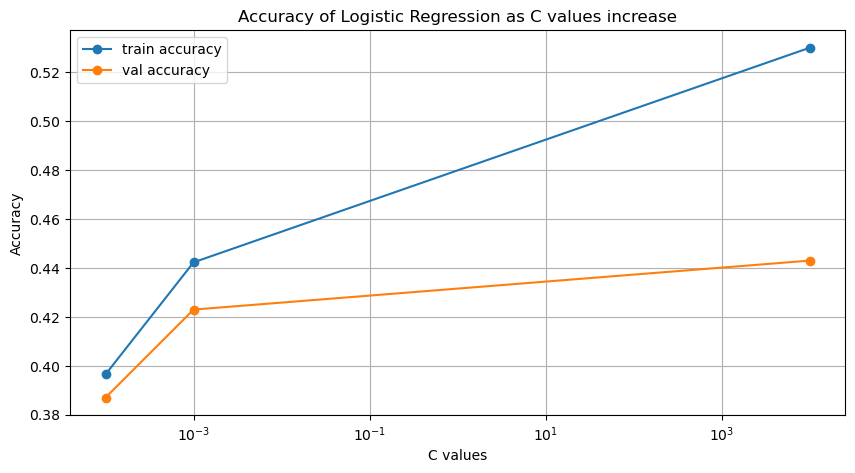

In [99]:
plt.figure(figsize=(10,5))
plt.plot(c_values, train_acc, label='train accuracy', marker='o')
plt.plot(c_values, val_acc, label='val accuracy', marker='o')

plt.xlabel('C values')
plt.ylabel('Accuracy')
plt.title("Accuracy of Logistic Regression as C values increase")
plt.xscale('log') #Using a log scale to better spread out the values
plt.grid()
plt.legend()
plt.show()

So these C-values are not necessarily better than the prior ones, ignoring them and moving on.

Based on what we saw with model performance when it was still a regression problem, I'm quite confident that XGBoost will perform the best. However we can try with a couple of other **non-tree based models** first to see if there's any difference.

### 2.3

### K nearest neighbours

In [102]:
from sklearn.neighbors import KNeighborsClassifier

In [101]:
#Scaling is important for KNN

scaler = StandardScaler()
scaler.fit(A_train)

A_train_ss = scaler.transform(A_train)

A_val_ss = scaler.transform(A_val)

In [103]:
train_acc=[]
val_acc=[]

for n in fib_list:
    
    print(f'Now running the KNN model with n={n}', end='\r')
    
    # Instantiate the KNN model 
    KNN_model= KNeighborsClassifier(n_neighbors = n)
    KNN_model.fit(A_train_ss, b_train)
    
    train_accuracy = KNN_model.score(A_train_ss, b_train)
    val_accuracy = KNN_model.score(A_val_ss, b_val)
    
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)

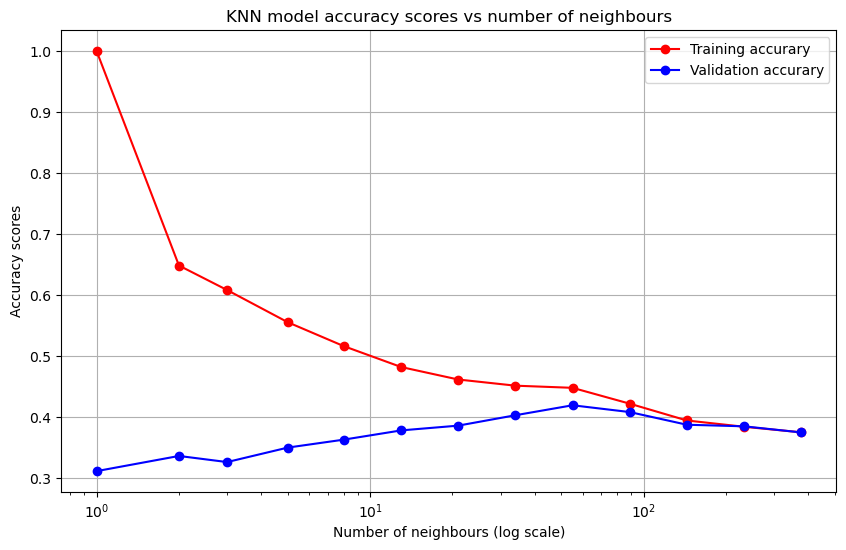

In [104]:
plt.figure(figsize=(10,6))
plt.plot(fib_list, train_acc, color='red', label = 'Training accurary', marker = 'o')
plt.plot(fib_list, val_acc, color='blue', label = 'Validation accurary', marker = 'o')
plt.xscale('log') #Using a log scale to better spread out the values
plt.xlabel('Number of neighbours (log scale)')
plt.ylabel('Accuracy scores')
plt.title('KNN model accuracy scores vs number of neighbours')
plt.legend()
plt.grid()
plt.show()

In [107]:
KNN_scores = pd.DataFrame({'Number of neighbours': fib_list, 'training score': train_acc, \
                          'validation score': val_acc})
KNN_scores['Train Percent difference vs. Val'] = round(((KNN_scores['training score']/\
                                              KNN_scores['validation score']) - 1)*100,1)

KNN_scores

,Number of neighbours,training score,validation score,Train Percent difference vs. Val
0,1,1.000000,0.311317,221.2
1,2,0.648418,0.336178,92.9
2,3,0.608240,0.326160,86.5
3,5,0.555442,0.349907,58.7
4,8,0.516377,0.362894,42.3
5,13,0.481952,0.378108,27.5
6,21,0.461538,0.385900,19.6
7,34,0.451424,0.402968,12.0
8,55,0.447898,0.419295,6.8
9,89,0.421917,0.408163,3.4


The best number of neighbours here would be n=8, but not our best model so far.

### 2.4

### Support Vector Classification

In [108]:
from sklearn.svm import SVC

In [109]:
c_range = [0.01, 0.1,1,10,100]
train_acc = []
val_acc = []

for c in c_range:
    
    print(f'Now running SVC with c={c}', end='\r')
    
    svc = SVC(C=c)
    
    svc.fit(A_train_ss, b_train)
    
    train_acc.append(svc.score(A_train_ss, b_train))
    val_acc.append(svc.score(A_val_ss, b_val))

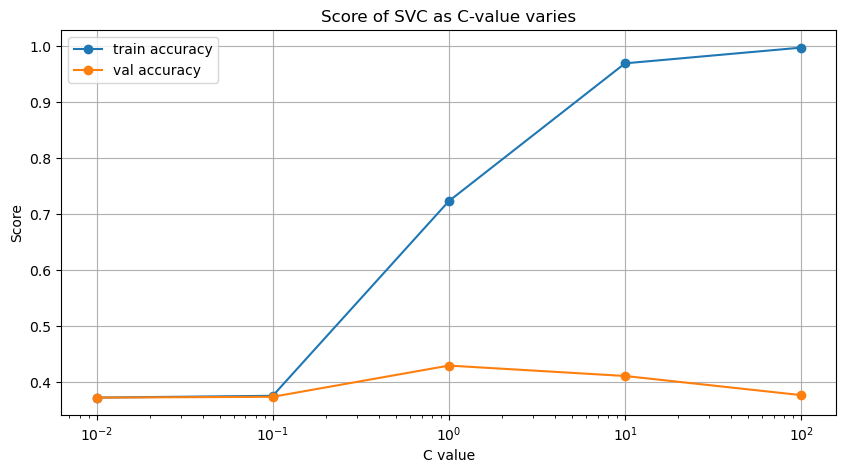

In [110]:
plt.figure(figsize=(10,5))
plt.plot(c_range, train_acc, label='train accuracy', marker='o')
plt.plot(c_range, val_acc, label='val accuracy', marker='o')

plt.xlabel('C value')
plt.ylabel('Score')
plt.title("Score of SVC as C-value varies")
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()

In [112]:
SVC_scores = pd.DataFrame({'C values': c_range, 'training score': train_acc, \
                          'validation score': val_acc})
SVC_scores['Train Percent difference vs. Val'] = round(((SVC_scores['training score']/\
                                              SVC_scores['validation score']) - 1)*100,1)

SVC_scores

,C values,training score,validation score,Train Percent difference vs. Val
0,0.01,0.372924,0.372913,0.0
1,0.10,0.376171,0.374397,0.5
2,1.00,0.723392,0.430056,68.2
3,10.00,0.969008,0.411503,135.5
4,100.00,0.997031,0.377365,164.2


The best scores we've gotten so far, similar to IMDB votes, is with XGBoost. Let's plot out our validation scores so far for the classification problem (where the models were not over-fitting.)

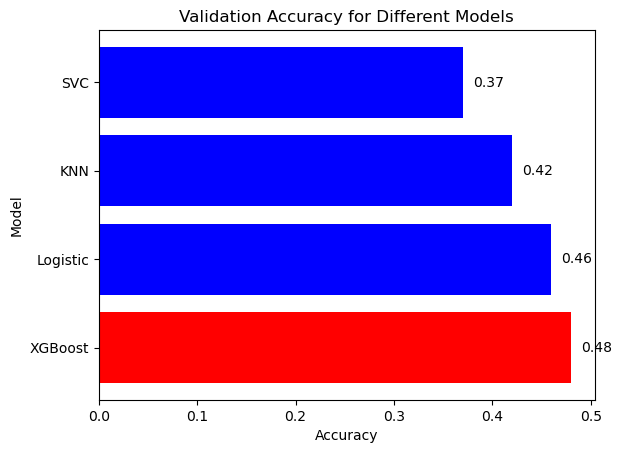

In [211]:
model_names = ['Logistic', 'KNN', 'SVC','XGBoost']
r2_scores = [0.46, 0.42, 0.37, 0.48]

# Sort the data in descending order
sorted_data = sorted(zip(r2_scores, model_names), reverse=True)
r2_scores_sorted, model_names_sorted = zip(*sorted_data)

# Set the colors for the bars
colours = ['blue' if model != 'XGBoost' else 'red' for model in model_names_sorted]

# Create the horizontal bar chart
bars = plt.barh(model_names_sorted, r2_scores_sorted, color=colours)

# Label the axes and set the title
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Validation Accuracy for Different Models')


# Add the values next to each bar
for bar, value in zip(bars, r2_scores_sorted):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, f"{value:.2f}", va='center')

# Display the chart
plt.show()

We can now move on to fine tune a couple of other parameters of XGBoost to decide what range to put in the grid search. Specifically the parameters of alpha and lambda.

### 2.5

### Fine-tuning XGBoost prior to Grid Search

In [113]:
a_range = [0.1,1,10,100,1000]
train_acc = []
val_acc = []

for a in a_range:
    
    print(f'Now running XGBoost with alpha={a}', end='\r')
    
    xgb = XGBClassifier(reg_alpha=a)
    
    xgb.fit(A_train, b_train)
    
    train_acc.append(xgb.score(A_train, b_train))
    val_acc.append(xgb.score(A_val, b_val))


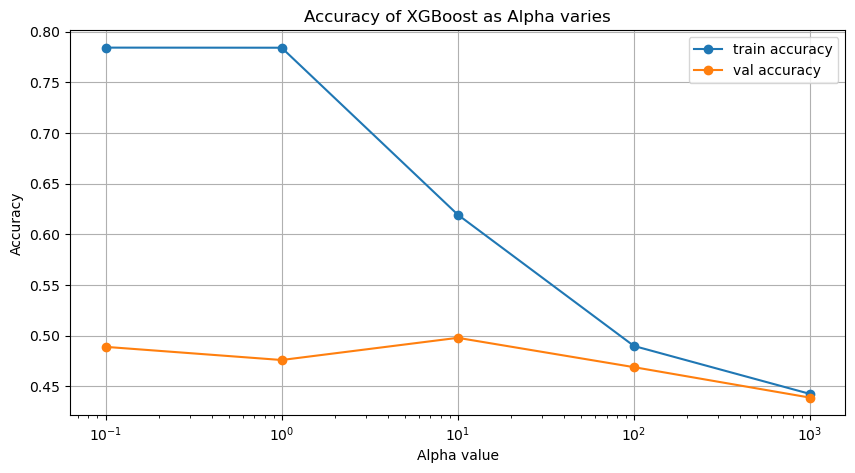

In [114]:
plt.figure(figsize=(10,5))
plt.plot(a_range, train_acc, label='train accuracy', marker='o')
plt.plot(a_range, val_acc, label='val accuracy', marker='o')

plt.xlabel('Alpha value')
plt.ylabel('Accuracy')
plt.title("Accuracy of XGBoost as Alpha varies")
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()

In [115]:
XGB_scores_alpha = pd.DataFrame({'alpha value': a_range, 'training score': train_acc, \
                          'validation score': val_acc})
XGB_scores_alpha['Train Percent difference vs. Val'] = round(((XGB_scores_alpha['training score']/\
                                              XGB_scores_alpha['validation score']) - 1)*100,1)

In [116]:
XGB_scores_alpha

,alpha value,training score,validation score,Train Percent difference vs. Val
0,0.1,0.784263,0.489054,60.4
1,1.0,0.784170,0.476067,64.7
2,10.0,0.619467,0.497959,24.4
3,100.0,0.489932,0.469017,4.5
4,1000.0,0.442609,0.438961,0.8


Now trying the hyperparameter lambda

In [117]:
l_range = [10,100,1000,10000]
train_acc = []
val_acc = []

for l in l_range:
    
    print(f'Now running XGBoost with lambda={l}', end='\r')
    
    xgb = XGBClassifier(reg_lambda=l)
    
    xgb.fit(A_train, b_train)
    
    train_acc.append(xgb.score(A_train, b_train))
    val_acc.append(xgb.score(A_val, b_val))

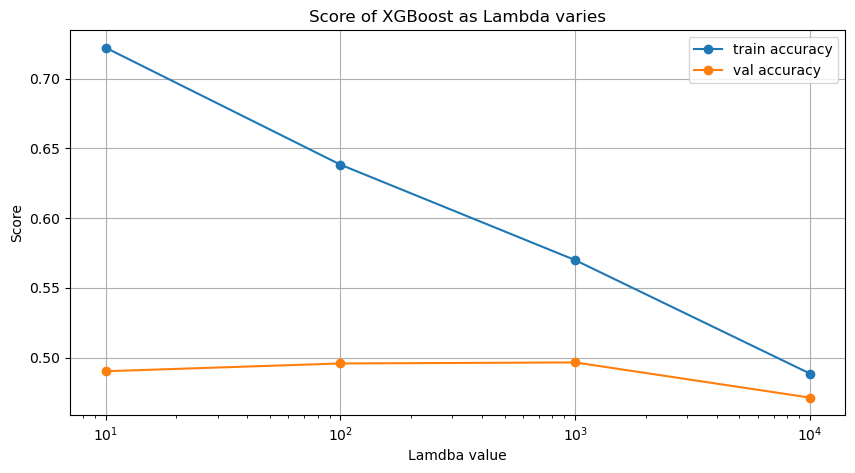

In [118]:
plt.figure(figsize=(10,5))
plt.plot(l_range, train_acc, label='train accuracy', marker='o')
plt.plot(l_range, val_acc, label='val accuracy', marker='o')

plt.xlabel('Lamdba value')
plt.ylabel('Score')
plt.title("Score of XGBoost as Lambda varies")
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()

In [120]:
XGB_scores_lambda = pd.DataFrame({'lambda value': l_range, 'training score': train_acc, \
                          'validation score': val_acc})
XGB_scores_lambda['Train Percent difference vs. Val'] = round(((XGB_scores_lambda['training score']/\
                                              XGB_scores_lambda['validation score']) - 1)*100,1)
XGB_scores_lambda

,lambda value,training score,validation score,Train Percent difference vs. Val
0,10,0.722186,0.490167,47.3
1,100,0.638304,0.495733,28.8
2,1000,0.569825,0.496475,14.8
3,10000,0.488448,0.471243,3.7


### 2.6

### Grid Search with Cross Validation

In [122]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
pipe = Pipeline([('model', XGBClassifier())], 
                       memory=cachedir)

Note : I'm going to start with a narrower field of hyperparameters, and then run another gridsearch seeing what the best performing parameters in the first one are. I'm doing it this way so as to not run the risk of the kernel crashing midway or it taking >6 hours to run the search.

In [123]:
#Adding the hyperparameters basis what performed the best in our initial tuning

ensemble_grid = [
    {'model': [XGBClassifier(seed=42)],
     'model__n_estimators': [15, 50],
     'model__max_depth': [6, 9, 12],
     'model__learning_rate': [0.1, 1],
     'model__reg_lambda' : [100, 1000],
     'model__reg_alpha' : [10, 50, 100]
    },
    ]

In [124]:
grid = GridSearchCV(pipe, param_grid=ensemble_grid, cv=5, \
                    n_jobs=-1, verbose=2, refit=False)

In [125]:
# Fit the grid search
fitted_grid = grid.fit(A_rem, b_rem)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__learning_rate=0.1, model__max_depth=6, model__n_estimators=15, model__reg_alpha=10, model__reg_lambda=100; total time=  41.8s
[CV] END model=XGBClassifier(base_sco

[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__learning_rate=0.1, model__max_depth=6, model__n_estimators=15, model__reg_alpha=10, model__reg_lambda=100; total time=  41.8s
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample

[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__learning_rate=0.1, model__max_depth=6, model__n_estimators=15, model__reg_alpha=10, model__reg_lambda=1000; total time=  41.9s
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsampl

[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__learning_rate=0.1, model__max_depth=6, model__n_estimators=15, model__reg_alpha=10, model__reg_lambda=1000; total time=  41.8s
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsampl

[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__learning_rate=0.1, model__max_depth=6, model__n_estimators=15, model__reg_alpha=10, model__reg_lambda=100; total time=  41.8s
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample

[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__learning_rate=0.1, model__max_depth=6, model__n_estimators=15, model__reg_alpha=10, model__reg_lambda=1000; total time=  41.8s
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsampl

[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__learning_rate=0.1, model__max_depth=6, model__n_estimators=15, model__reg_alpha=10, model__reg_lambda=100; total time=  41.8s
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample

[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__learning_rate=0.1, model__max_depth=6, model__n_estimators=15, model__reg_alpha=10, model__reg_lambda=100; total time=  41.9s
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample

[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__learning_rate=0.1, model__max_depth=12, model__n_estimators=15, model__reg_alpha=100, model__reg_lambda=100; total time= 1.7min
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsamp

[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__learning_rate=0.1, model__max_depth=12, model__n_estimators=15, model__reg_alpha=100, model__reg_lambda=100; total time= 1.7min
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsamp

In [ ]:
pd.set_option('display.max_colwidth', -1)

In [127]:
results_df = pd.DataFrame(fitted_grid.cv_results_)

# Display the parameters and mean_test_score columns for all combinations
results_df[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head(5)

,params,mean_test_score
36,"{'model': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=None, ...), 'model__learning_rate': 1, 'model__max_depth': 6, 'model__n_estimators': 15, 'model__reg_alpha': 10, 'model__reg_lambda': 100}",0.499480
48,"{'model': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=None, ...), 'model__learning_rate': 1, 'model__max_depth': 9, 'model__n_estimators': 15, 'model__reg_alpha': 10, 'model__reg_lambda': 100}",0.496510
43,"{'model': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=None, ...), 'model__learning_rate': 1, 'model__max_depth': 6, 'model__n_estimators': 50, 'model__reg_alpha': 10, 'model__reg_lambda': 1000}",0.495174
42,"{'model': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=None, ...), 'model__learning_rate': 1, 'model__max_depth': 6, 'model__n_estimators': 50, 'model__reg_alpha': 10, 'model__reg_lambda': 100}",0.494729
55,"{'model': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=None, ...), 'model__learning_rate': 1, 'model__max_depth': 9, 'model__n_estimators': 50, 'model__reg_alpha': 10, 'model__reg_lambda': 1000}",0.493987


[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__learning_rate=1, model__max_depth=9, model__n_estimators=15, model__reg_alpha=100, model__reg_lambda=1000; total time= 1.5min
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample

[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__learning_rate=0.1, model__max_depth=12, model__n_estimators=50, model__reg_alpha=10, model__reg_lambda=1000; total time= 5.9min
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsamp

[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__learning_rate=0.1, model__max_depth=12, model__n_estimators=50, model__reg_alpha=10, model__reg_lambda=100; total time= 6.0min
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsampl

[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__learning_rate=0.1, model__max_depth=12, model__n_estimators=50, model__reg_alpha=10, model__reg_lambda=100; total time= 5.9min
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsampl

[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__learning_rate=0.1, model__max_depth=12, model__n_estimators=15, model__reg_alpha=100, model__reg_lambda=100; total time= 1.7min
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsamp

[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__learning_rate=1, model__max_depth=9, model__n_estimators=15, model__reg_alpha=100, model__reg_lambda=100; total time= 1.0min
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_

[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__learning_rate=0.1, model__max_depth=12, model__n_estimators=15, model__reg_alpha=100, model__reg_lambda=100; total time= 1.7min
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsamp

[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__learning_rate=0.1, model__max_depth=12, model__n_estimators=50, model__reg_alpha=10, model__reg_lambda=100; total time= 6.0min
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsampl

Ssetting up another, narrower grid search to see if we can bump up the accuracy even further.

In [130]:
ensemble_grid_1 = [
    {'model': [XGBClassifier(seed=42)],
     'model__booster': ['gbtree', 'dart'],
     'model__n_estimators': [8, 15, 30],
     'model__max_depth': [3, 6],
     'model__learning_rate': [0.3, 1],
     'model__reg_alpha' : [10],
     'model__reg_lambda' : [100],
    }
    ]

In [131]:
grid_1 = GridSearchCV(pipe, param_grid=ensemble_grid_1, cv=5, \
                    n_jobs=-1, verbose=2, refit=False)

In [132]:
# Fit the grid search
fitted_grid_1 = grid_1.fit(A_rem, b_rem)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__booster=gbtree, model__learning_rate=0.3, model__max_depth=3, model__n_estimators=8, model__reg_alpha=10, model__reg_lambda=100; total time=  11.3s
[CV] END model=

[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__booster=gbtree, model__learning_rate=0.3, model__max_depth=3, model__n_estimators=8, model__reg_alpha=10, model__reg_lambda=100; total time=  10.8s
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
 

[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__booster=gbtree, model__learning_rate=0.3, model__max_depth=3, model__n_estimators=15, model__reg_alpha=10, model__reg_lambda=100; total time=  19.6s
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,


[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__booster=gbtree, model__learning_rate=0.3, model__max_depth=3, model__n_estimators=15, model__reg_alpha=10, model__reg_lambda=100; total time=  19.6s
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,


[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__booster=gbtree, model__learning_rate=0.3, model__max_depth=3, model__n_estimators=8, model__reg_alpha=10, model__reg_lambda=100; total time=  10.9s
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
 

[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__booster=gbtree, model__learning_rate=0.3, model__max_depth=3, model__n_estimators=8, model__reg_alpha=10, model__reg_lambda=100; total time=  11.4s
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
 

[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__booster=gbtree, model__learning_rate=0.3, model__max_depth=3, model__n_estimators=8, model__reg_alpha=10, model__reg_lambda=100; total time=  11.0s
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
 

[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), model__booster=gbtree, model__learning_rate=0.3, model__max_depth=3, model__n_estimators=15, model__reg_alpha=10, model__reg_lambda=100; total time=  19.6s
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,


In [134]:
results_df_1 = pd.DataFrame(fitted_grid_1.cv_results_)

# Display the parameters and mean_test_score columns for all combinations
results_df_1[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head(5)

,params,mean_test_score
22,"{'model': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=None, ...), 'model__booster': 'dart', 'model__learning_rate': 1, 'model__max_depth': 6, 'model__n_estimators': 15, 'model__reg_alpha': 10, 'model__reg_lambda': 100}",0.499480
10,"{'model': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=None, ...), 'model__booster': 'gbtree', 'model__learning_rate': 1, 'model__max_depth': 6, 'model__n_estimators': 15, 'model__reg_alpha': 10, 'model__reg_lambda': 100}",0.499480
5,"{'model': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=None, ...), 'model__booster': 'gbtree', 'model__learning_rate': 0.3, 'model__max_depth': 6, 'model__n_estimators': 30, 'model__reg_alpha': 10, 'model__reg_lambda': 100}",0.499480
17,"{'model': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=None, ...), 'model__booster': 'dart', 'model__learning_rate': 0.3, 'model__max_depth': 6, 'model__n_estimators': 30, 'model__reg_alpha': 10, 'model__reg_lambda': 100}",0.499480
23,"{'model': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=None, ...), 'model__booster': 'dart', 'model__learning_rate': 1, 'model__max_depth': 6, 'model__n_estimators': 30, 'model__reg_alpha': 10, 'model__reg_lambda': 100}",0.497476


No improvement whatsoever in the accuracy score basis this additional fine tuning, so let's lock in the hyperparameters of the best performing model.

In [135]:
from joblib import dump

# Manually create the best estimator using the best hyperparameters
best_XGB_classifier = XGBClassifier(n_estimators=15, max_depth=6, reg_lambda=100, \
                           reg_alpha=10, learning_rate=1)

# Fit the best model on the entire dataset (or train dataset)
best_XGB_classifier.fit(A_rem, b_rem)

# Save the best model to a file
dump(best_XGB_classifier, 'models/XGBClassifier_Score.joblib')

['models/XGBClassifier_Score.joblib']

### Trying logistic regression grid search

Because logistic regression came close to XGBoost in the initial tests, I'm just curious to see what the results of a grid search would look like.

In [212]:
# Set up a directory to cache the pipeline results
cachedir1 = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline = Pipeline([('scaler', StandardScaler()), 
                        ('dim_reducer', PCA()), 
                        ('model', LogisticRegression())], 
                       memory=cachedir1)

In [213]:
# Setting a range of C values to try
c_values = [0.001, 0.01, 0.1] 


# Parameter grid
logreg_param_grid = [
    
    # l1 penalty, without PCA
    {'scaler': [None, StandardScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(penalty='l1', random_state=23, n_jobs=-1,max_iter=10000)],
     'model__C': c_values},
    
    # l1 penality, with PCA
    {'scaler': [StandardScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.9, 0.85],
     'model': [LogisticRegression(penalty='l1', random_state=23, n_jobs=-1,max_iter=10000)],
     'model__C': c_values},
    
    # l2 (default) without PCA
    {'scaler': [None, StandardScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(solver='lbfgs', random_state=23, n_jobs=-1,max_iter=10000)],
     'model__C': c_values},
    
    # l2 (default) with PCA
    {'scaler': [StandardScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.9, 0.85],
     'model': [LogisticRegression(solver='lbfgs', random_state=23, n_jobs=-1,max_iter=10000)],
     'model__C': c_values}
]

In [214]:
# Instantiate the log reg grid search
lrgrid = GridSearchCV(my_pipeline, param_grid=logreg_param_grid, 
                         cv=5, n_jobs=-1, verbose=2, refit=False)

# Fit the log reg grid search
fitted_lrgrid = lrgrid.fit(A_rem, b_rem)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/arjunlokur/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 1.55s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
/Users/arjunlokur/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

[CV] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=23), model__C=0.001, scaler=None; total time=   0.5s
[CV] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=23), model__C=0.01, scaler=None; total time=   0.1s
[CV] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=23), model__C=0.01, scaler=None; total time=   0.0s
[CV] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=23), model__C=0.01, scaler=StandardScaler(); total time=   1.2s
[CV] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=23), model__C=0.1, scaler=None; total time=   0.1s
[CV] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=23), model__C=0.001, scaler=StandardScaler(); total time=   

/Users/arjunlokur/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/arjunlokur/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

[CV] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=23), model__C=0.001, scaler=StandardScaler(); total time=   1.8s
[CV] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=23), model__C=0.1, scaler=None; total time=   0.1s
[CV] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=23), model__C=0.1, scaler=None; total time=   0.0s
[CV] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=23), model__C=0.1, scaler=StandardScaler(); total time=   0.3s
[CV] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=23), model__C=0.001, scaler=StandardScaler(); total time=   6.5s
[CV] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=23), 

In [215]:
results_df = pd.DataFrame(fitted_lrgrid.cv_results_)

# Display the parameters and mean_test_score columns for all combinations, and take out the top 10
results_df[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head(5)

,params,mean_test_score
14,"{'dim_reducer': None, 'model': LogisticRegression(max_iter=10000, n_jobs=-1, random_state=23), 'model__C': 0.01, 'scaler': None}",0.469344
16,"{'dim_reducer': None, 'model': LogisticRegression(max_iter=10000, n_jobs=-1, random_state=23), 'model__C': 0.1, 'scaler': None}",0.459472
13,"{'dim_reducer': None, 'model': LogisticRegression(max_iter=10000, n_jobs=-1, random_state=23), 'model__C': 0.001, 'scaler': StandardScaler()}",0.442251
21,"{'dim_reducer': PCA(), 'dim_reducer__n_components': 0.85, 'model': LogisticRegression(max_iter=10000, n_jobs=-1, random_state=23), 'model__C': 0.001, 'scaler': StandardScaler()}",0.436313
15,"{'dim_reducer': None, 'model': LogisticRegression(max_iter=10000, n_jobs=-1, random_state=23), 'model__C': 0.01, 'scaler': StandardScaler()}",0.435125


We see improvement vs the Logistic regression model prior to the grid search, but it doesn't match up to the XGBoost performance, which remains our best model.

### 2.7

### Model Evaluation

In [137]:
from joblib import load

In [138]:
from sklearn.metrics import accuracy_score

# Load the saved model
best_model = load('models/XGBClassifier_Score.joblib')

# Make predictions using the loaded model
b_pred = best_model.predict(A_test)

# Calculate and print accuracy
accuracy = accuracy_score(b_test, b_pred)
print(f'Accuracy on Test Data set: {accuracy:.4f}')


Accuracy on Test Data set: 0.4964


This is a good score on our final test data as it's very close to our highest validation score from the grid search (0.499), which means that our model was not overfitting to the data.

And the **model's improvement over baseline accuracy is**:

In [203]:
print(round((results_df_1['mean_test_score'].max() - baseline),3)*100,'%')

12.7 %


Let's have a look at the classification report and the confusion matrix to see how the model's precision and recall changed for different classes.

In [148]:
from sklearn.metrics import classification_report

# Make predictions using the loaded model
b_pred = best_model.predict(A_test)

# Print classification report
report = classification_report(b_test, b_pred)
print(report)


              precision    recall  f1-score   support

         0.0       0.63      0.34      0.44       477
         1.0       0.52      0.64      0.58      1256
         2.0       0.44      0.50      0.47      1026
         3.0       0.47      0.35      0.40       539
         4.0       1.00      0.01      0.03        70

    accuracy                           0.50      3368
   macro avg       0.61      0.37      0.38      3368
weighted avg       0.51      0.50      0.48      3368



The model seems to be performing the best with class 1, with an F1 score of 0.58. Class 1 is titles rated between 5-6.5 on IMDB. It's possible that this is the case because it is the most frequent class - though we saw that upsampling the lowest frequency class (class 4) actually decreased the accuracy score of the model.

The precision and recall scores for class 4 (which is titles rated 8.5+ on IMDB) is the most interesting, with a precision of 1 and a recall of 0.01. This means that whatever the model has guessed as class 4 is indeed class 4 (100% precision), where it missed 99% of the actual class 4 instances (1% recall). So it seems like the model is being very selective about which titles are rated 8.5 or higher, and attributing lower scores to a lot of titles that are high-rated in reality.

Let's plot a confusion matrix to see how the classes are actually being identified.

In [146]:
from sklearn.metrics import confusion_matrix

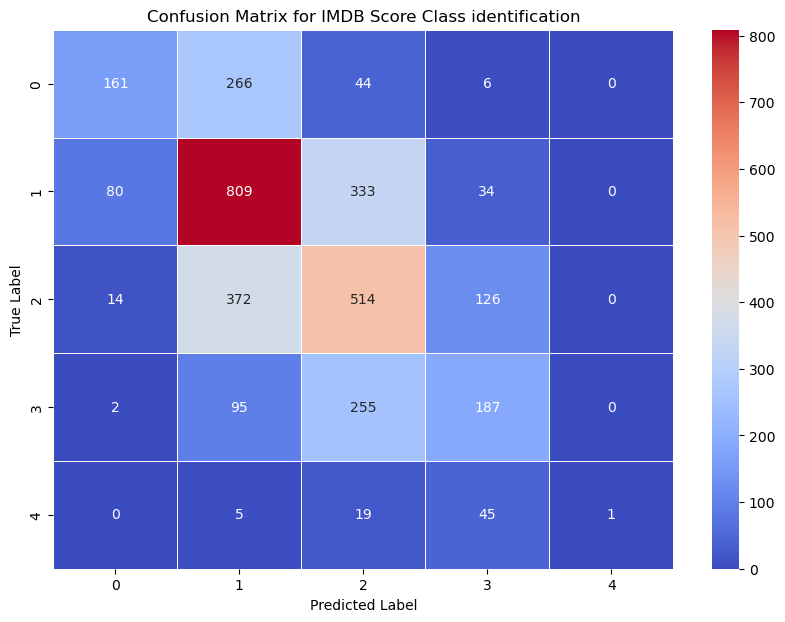

In [229]:
# Make predictions using the loaded model
b_pred = best_model.predict(A_test)

# Create the confusion matrix
cm = confusion_matrix(b_test, b_pred)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', linewidths=0.5, cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for IMDB Score Class identification')
plt.savefig('visuals/imdb_score_confusion_matrix.png')
plt.show()


The confusion matrix confirms what we alreadt know from the classification report - the model is best with class 1 and the worst with class 4 (100% precision and 1% recall). I'm curious to know which was the one title that was correctly identified as Class 4. Let's find out it's index number and then cross-reference it with the 'all_titles' dataframe from our 1st Notebook.

In [149]:
#Finding out which title was correct predicted as class 4
class_label = 4

# Create a DataFrame with true and predicted labels
comparison_df = pd.DataFrame({'true_label': b_test, 'predicted_label': b_pred})

# Find the row index where true_label and predicted_label match for the class_label
matching_rows = comparison_df[(comparison_df['true_label'] == class_label) & (comparison_df['predicted_label'] == class_label)]

# Display the matching rows
print(matching_rows)

     true_label  predicted_label
588  4.0         4              


The index 588 corresponds with a TV show called Shameless, starring William H. Macy, which is available on Netflix.

## Conclusion_

In this notebook, we tried various models to predict the IMDB score as a regression problem. We switched midway to a multi-class classification problem which did improve the accuracy scores. We also tried upsampling which did not help. Finally, we selected XGBoost as the best performing model and procceded with a grid search to further tune its hyperparameters. In the model evaluation, we saw that it performed best with class 1, and the worst with class 4, which were the most and least frequent classes respectively. 